In [104]:
import math
import numpy as np
import pandas as pd
from datetime import datetime, date

In [105]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib notebook

import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# 1. Data Cleaning

### Remove NA values

In [106]:
df = pd.read_pickle("indego_df.pkl")
df.reset_index(drop=True, inplace=True)
df.dropna(axis=0, how="any", inplace=True)
df.isnull().sum()

trip_id                0
duration               0
start_time             0
end_time               0
start_station          0
start_lat              0
start_lon              0
end_station            0
end_lat                0
end_lon                0
bike_id                0
plan_duration          0
trip_route_category    0
passholder_type        0
dtype: int64

In [107]:
df.shape[0]
df.dtypes

1961157

trip_id                         int64
duration                      float64
start_time             datetime64[ns]
end_time               datetime64[ns]
start_station                 float64
start_lat                     float64
start_lon                     float64
end_station                     int64
end_lat                       float64
end_lon                       float64
bike_id                        object
plan_duration                   int64
trip_route_category            object
passholder_type                object
dtype: object

## Examine the bike trip duration

In [108]:
df["duration"].describe()

count    1.961157e+06
mean     2.147079e+01
std      5.798235e+01
min      1.000000e+00
25%      8.000000e+00
50%      1.200000e+01
75%      1.900000e+01
max      1.440000e+03
Name: duration, dtype: float64

<IPython.core.display.Javascript object>


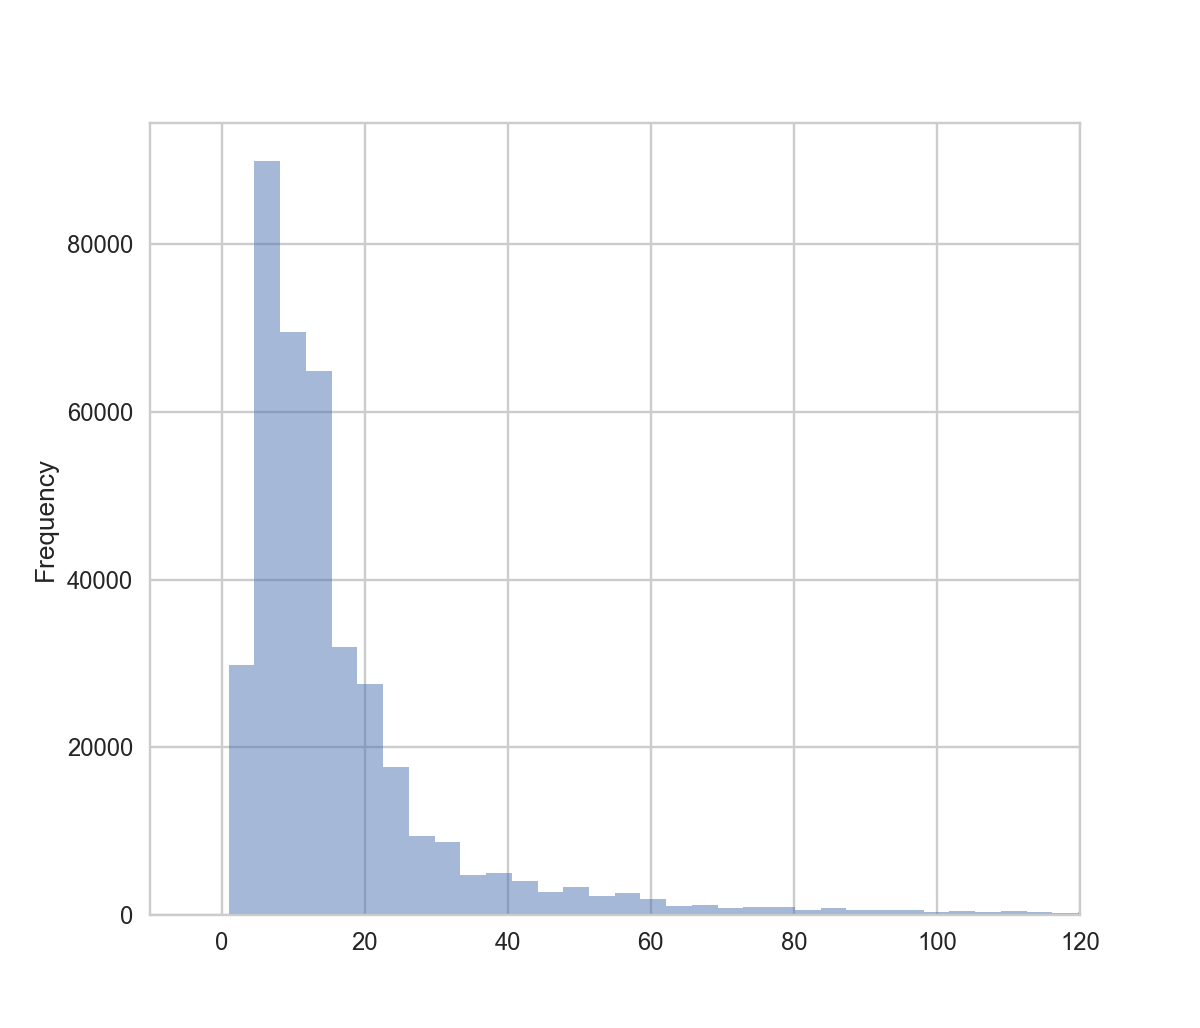

In [109]:
f0, ax0 = plt.subplots(figsize=(7, 6))
df["duration"].sample(frac=0.2).plot(kind="hist",xlim=(-10, 120), alpha=0.5, bins=400)

### Remove rows with duration not equal (end_time-start_time)

In [114]:
temp = df.end_time - df.start_time
temp = temp/np.timedelta64(1, 'm')
test = df.duration - temp
df.drop(test[test!=0].index, axis=0, inplace=True)

# 2. Examine coordinates

#### Remove the rows with zero start/end coordinates

In [115]:
sum(df["start_lat"]==0); sum(df["end_lon"]==0)

52

5509

In [116]:
df_new = df[(df["start_lat"]!=0) & (df["end_lat"]!=0)].copy()
df_new.shape

(1954638, 14)

In [117]:
df_new["start_station"] = df_new["start_station"].astype(int)
df_new.dtypes

trip_id                         int64
duration                      float64
start_time             datetime64[ns]
end_time               datetime64[ns]
start_station                   int64
start_lat                     float64
start_lon                     float64
end_station                     int64
end_lat                       float64
end_lon                       float64
bike_id                        object
plan_duration                   int64
trip_route_category            object
passholder_type                object
dtype: object

# 3. Check passholder types

In [118]:
df_new["passholder_type"].unique()

array(['Indego30', 'Walk-up', 'IndegoFlex', 'Indego365', 'One Day Pass',
       'Two Day Pass'], dtype=object)

### Calculate trips percentage according to passholder types

In [120]:
df_new.groupby("passholder_type").count()/df_new.shape[0]

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category
passholder_type,,,,,,,,,,,,,
Indego30,0.814854,0.814854,0.814854,0.814854,0.814854,0.814854,0.814854,0.814854,0.814854,0.814854,0.814854,0.814854,0.814854
Indego365,0.008914,0.008914,0.008914,0.008914,0.008914,0.008914,0.008914,0.008914,0.008914,0.008914,0.008914,0.008914,0.008914
IndegoFlex,0.012572,0.012572,0.012572,0.012572,0.012572,0.012572,0.012572,0.012572,0.012572,0.012572,0.012572,0.012572,0.012572
One Day Pass,0.003410,0.003410,0.003410,0.003410,0.003410,0.003410,0.003410,0.003410,0.003410,0.003410,0.003410,0.003410,0.003410
Two Day Pass,0.000815,0.000815,0.000815,0.000815,0.000815,0.000815,0.000815,0.000815,0.000815,0.000815,0.000815,0.000815,0.000815
Walk-up,0.159435,0.159435,0.159435,0.159435,0.159435,0.159435,0.159435,0.159435,0.159435,0.159435,0.159435,0.159435,0.159435


<IPython.core.display.Javascript object>


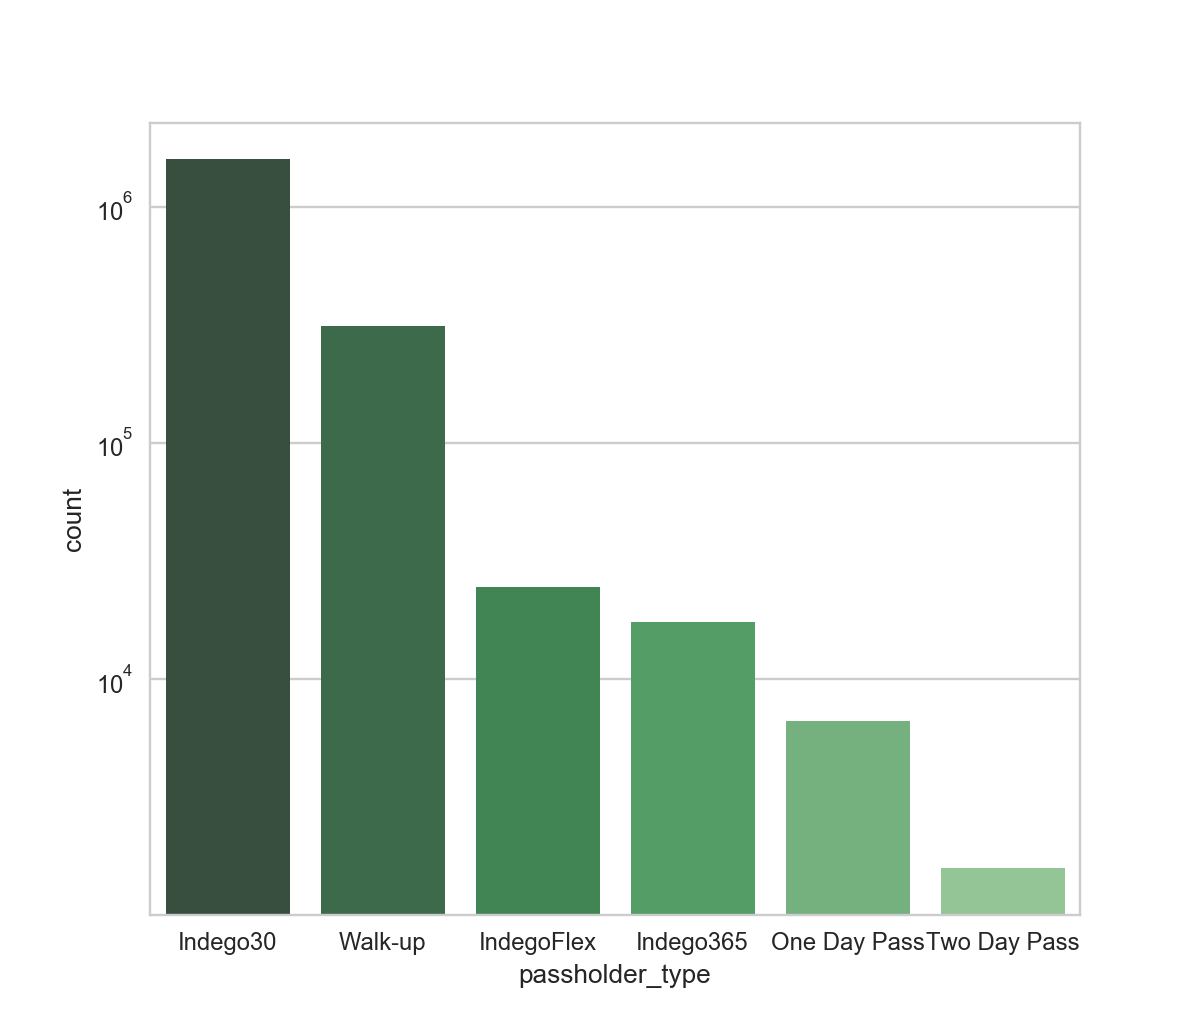

In [121]:
f1, ax1 = plt.subplots(figsize=(7, 6))
ax1.set(yscale="log")
sns.countplot(x="passholder_type", data=df_new, palette="Greens_d");

# 4. Plot some stations examples on googlemap

In [124]:
df_sample = df_new.sample(frac=0.01)

In [125]:
from gmplot import gmplot

gmap = gmplot.GoogleMapPlotter.from_geocode("Philadelphia")

# gmap.scatter(lats, lons, 'cornflowerblue', edge_width=10)
gmap.heatmap(df_sample["start_lat"], df_sample["start_lon"])
gmap.draw("Philadelphia_heatmap.html")

In [126]:
import gmaps
gmaps.configure(api_key="***")

fig = gmaps.figure()
fig.add_layer(gmaps.heatmap_layer(zip(df_sample["start_lat"], df_sample["start_lon"])))
# fig

# 5. Calculate the trip distances

In [127]:
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371 # Radius of earth in km. (3956 for miles)
    return c * r

In [128]:
def estimate_distance(df):
    return haversine(df['start_lat'], df['start_lon'], df['end_lat'], df['end_lon'])

In [129]:
df_new["distance"] = estimate_distance(df_new)
df_new["distance"].head(5)

0    0.930208
1    1.379643
2    1.077087
3    0.000000
4    0.892409
Name: distance, dtype: float64

<IPython.core.display.Javascript object>


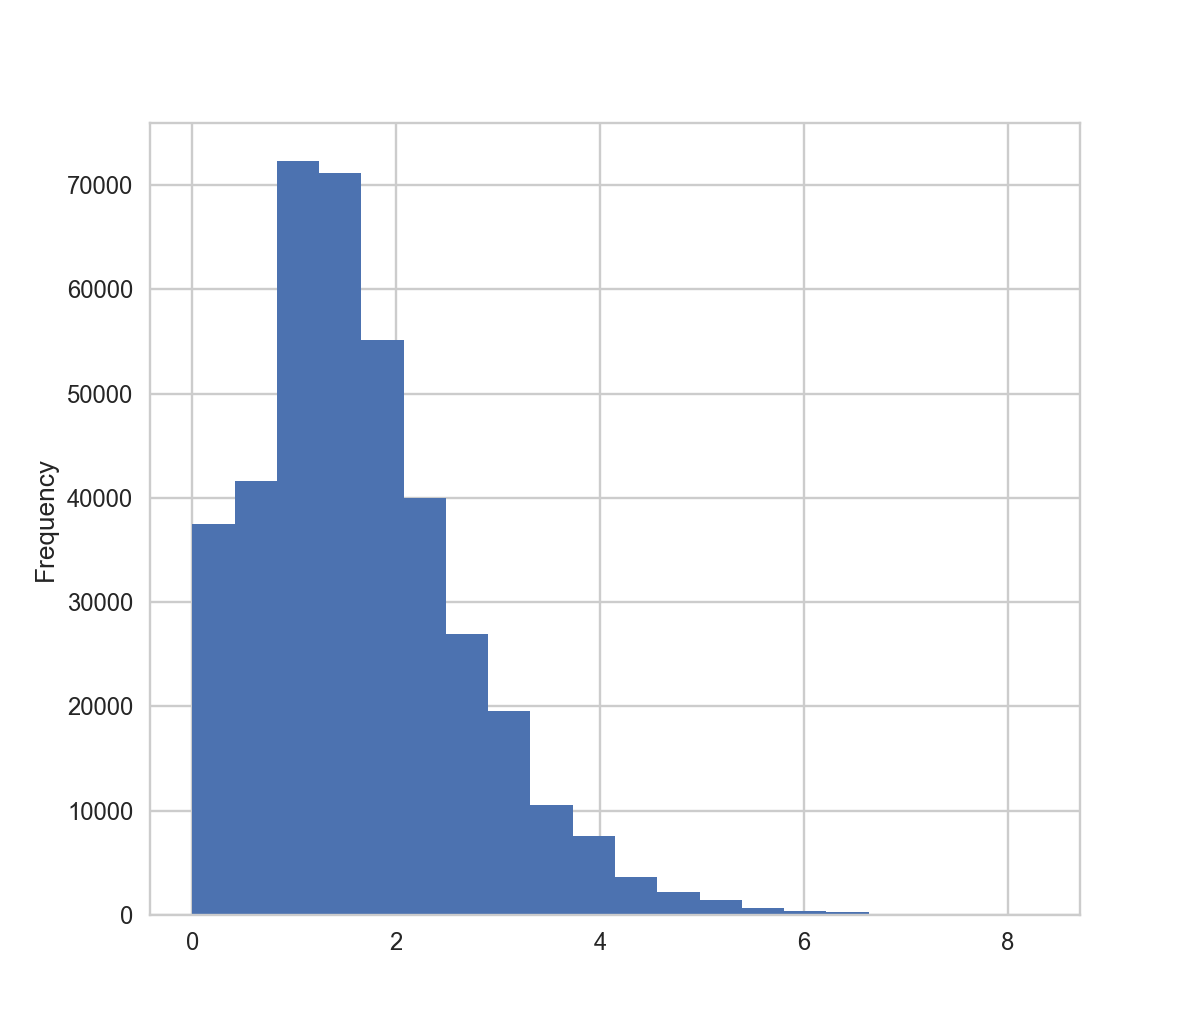

In [33]:
f2, ax2 = plt.subplots(figsize=(7, 6))
df_new["distance"].sample(frac=0.2).plot(kind="hist", bins=20)

# 6. Bucktize start time into weekday and hour

In [130]:
df_new["start_time"].tail(3)

1972665   2015-06-30 23:41:00
1972666   2015-06-30 23:48:00
1972667   2015-06-30 23:49:00
Name: start_time, dtype: datetime64[ns]

In [131]:
df_new["start_weekday"] = df_new["start_time"].dt.weekday_name
df_new["start_weekday"] = pd.Categorical(df_new["start_weekday"], 
                                         categories=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'], ordered=True)
df_new["start_weekday"].count()

1954638

In [132]:
df_new["start_hour"] = df_new["start_time"].dt.hour
df_new["start_hour"].unique(); df_new["start_weekday"].unique() 

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

[Friday, Saturday, Sunday, Monday, Tuesday, Wednesday, Thursday]
Categories (7, object): [Sunday < Monday < Tuesday < Wednesday < Thursday < Friday < Saturday]

In [134]:
df_new['start_weekday'].unique()

[Friday, Saturday, Sunday, Monday, Tuesday, Wednesday, Thursday]
Categories (7, object): [Sunday < Monday < Tuesday < Wednesday < Thursday < Friday < Saturday]

In [135]:
weekday_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

<IPython.core.display.Javascript object>


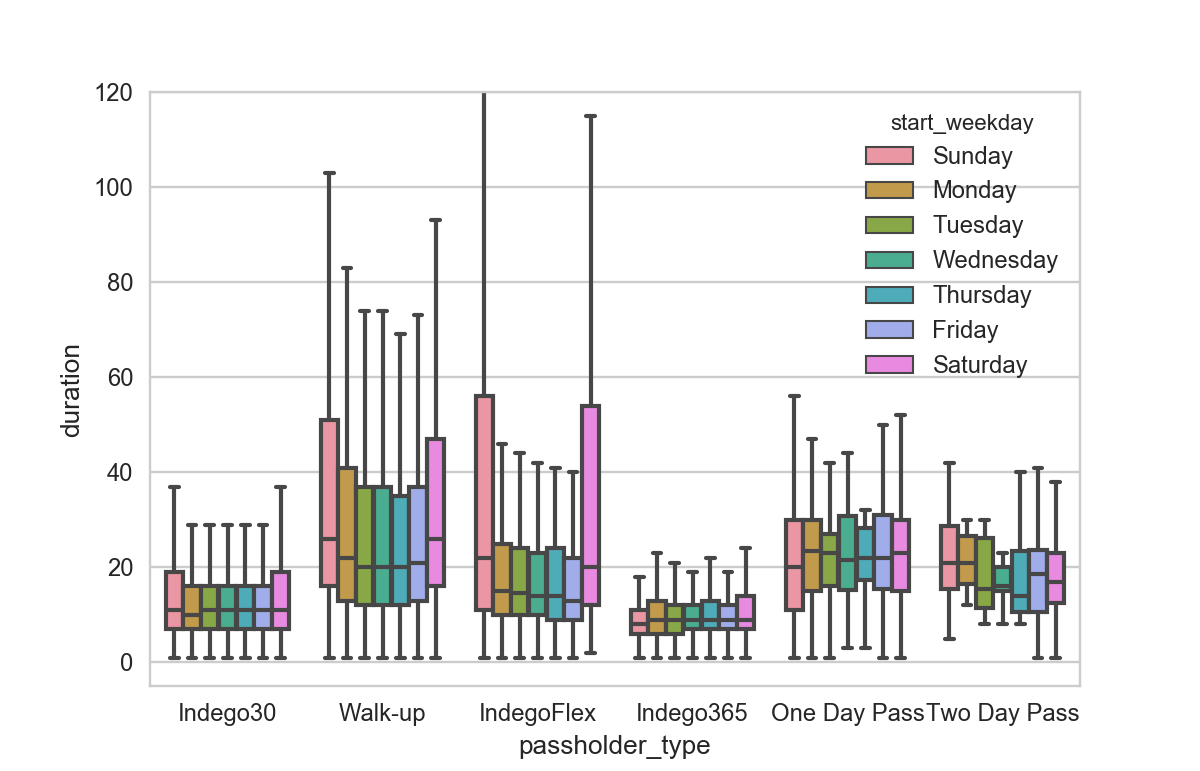

(-5, 120)

In [136]:
f2, ax2 = plt.subplots(figsize=(7, 4.5))
ax2 = sns.boxplot(x='passholder_type', y='duration', hue='start_weekday', whis=1.5, showfliers=False, data=df_new.sample(frac=0.1));
ax2.set_ylim([-5, 120])
f2.savefig('week_passholder_duration.png', bbox_inches='tight')

### Plot duration vs all stations

<IPython.core.display.Javascript object>


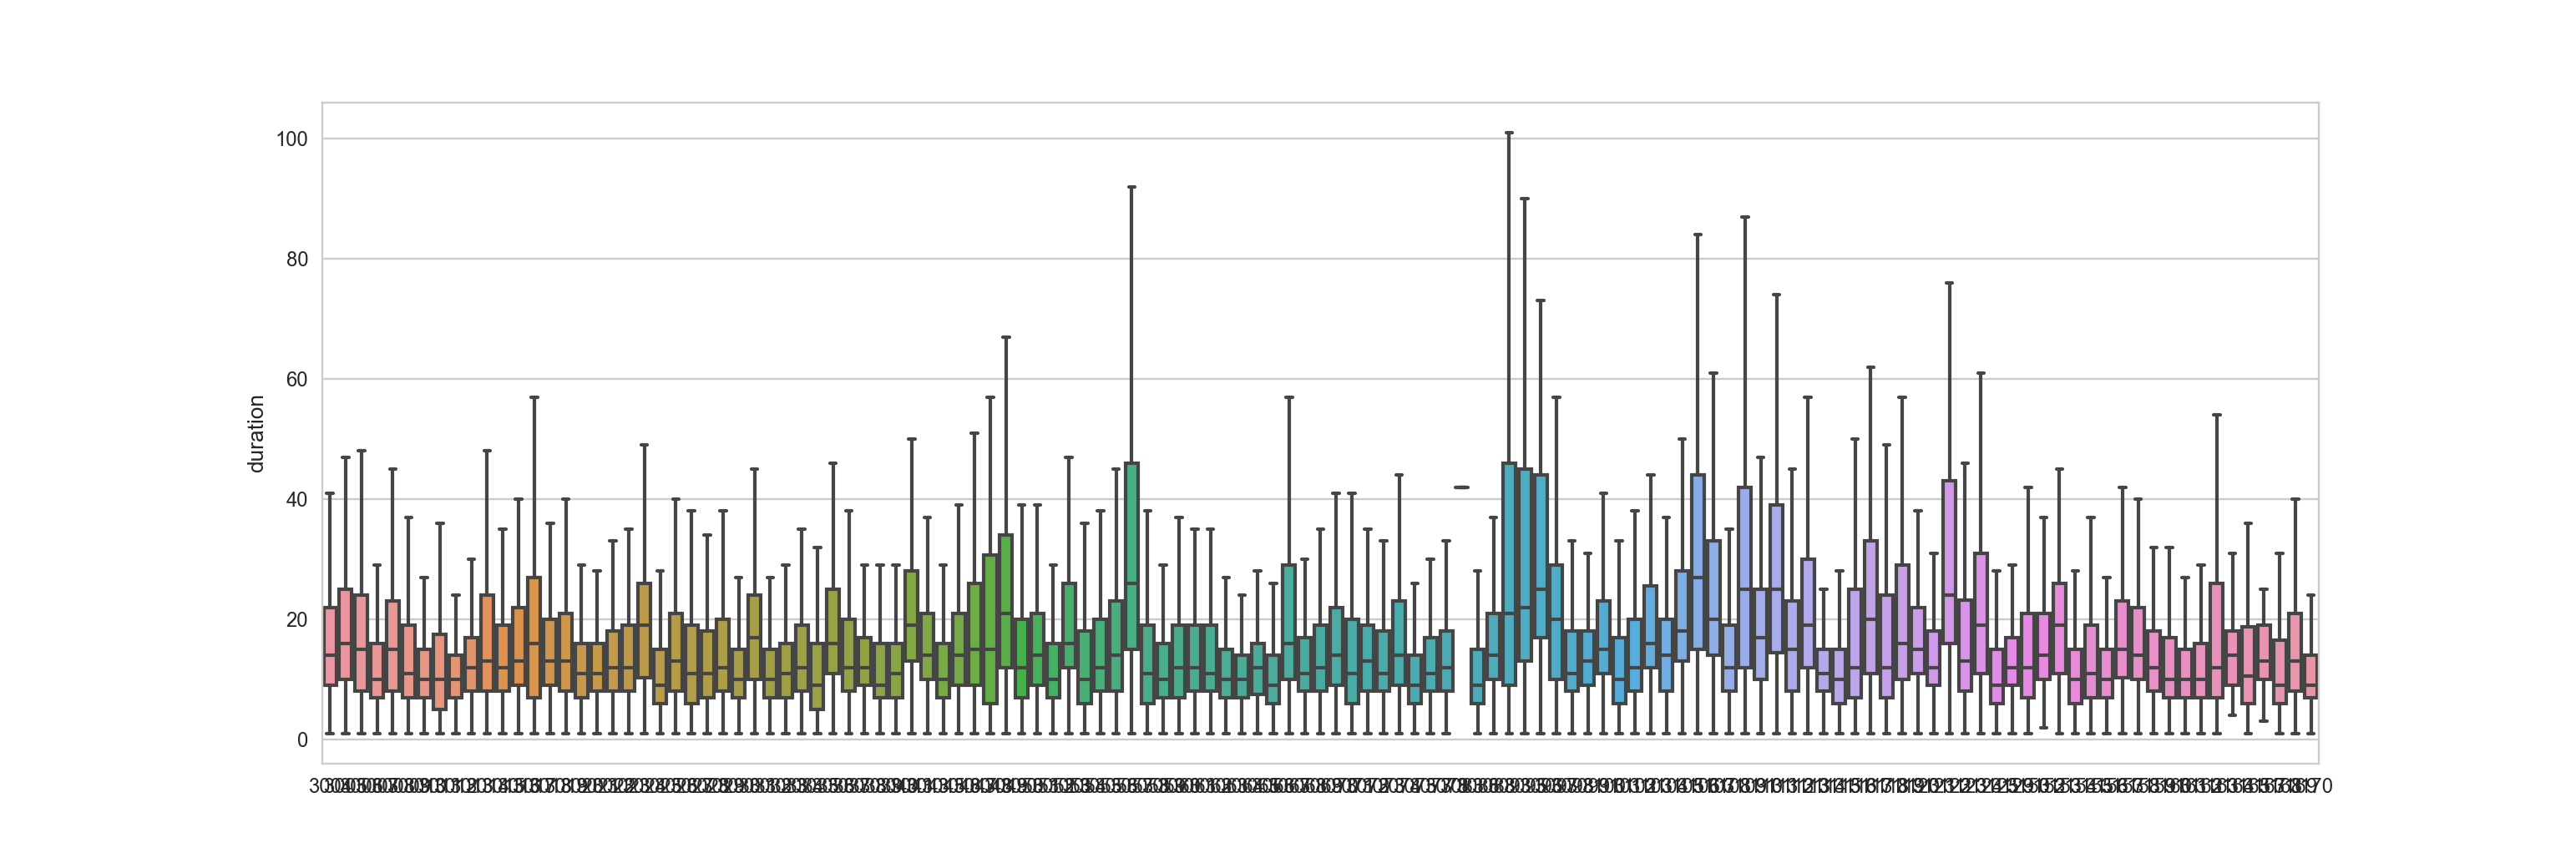

In [46]:
f3, ax3 = plt.subplots(figsize=(18, 6))
ax3 = sns.boxplot(x='start_station', y='duration', showfliers=False, data=df_new.sample(frac=0.1))
ax3.set(xlabel="")


### Plot duration vs start_hour

<IPython.core.display.Javascript object>


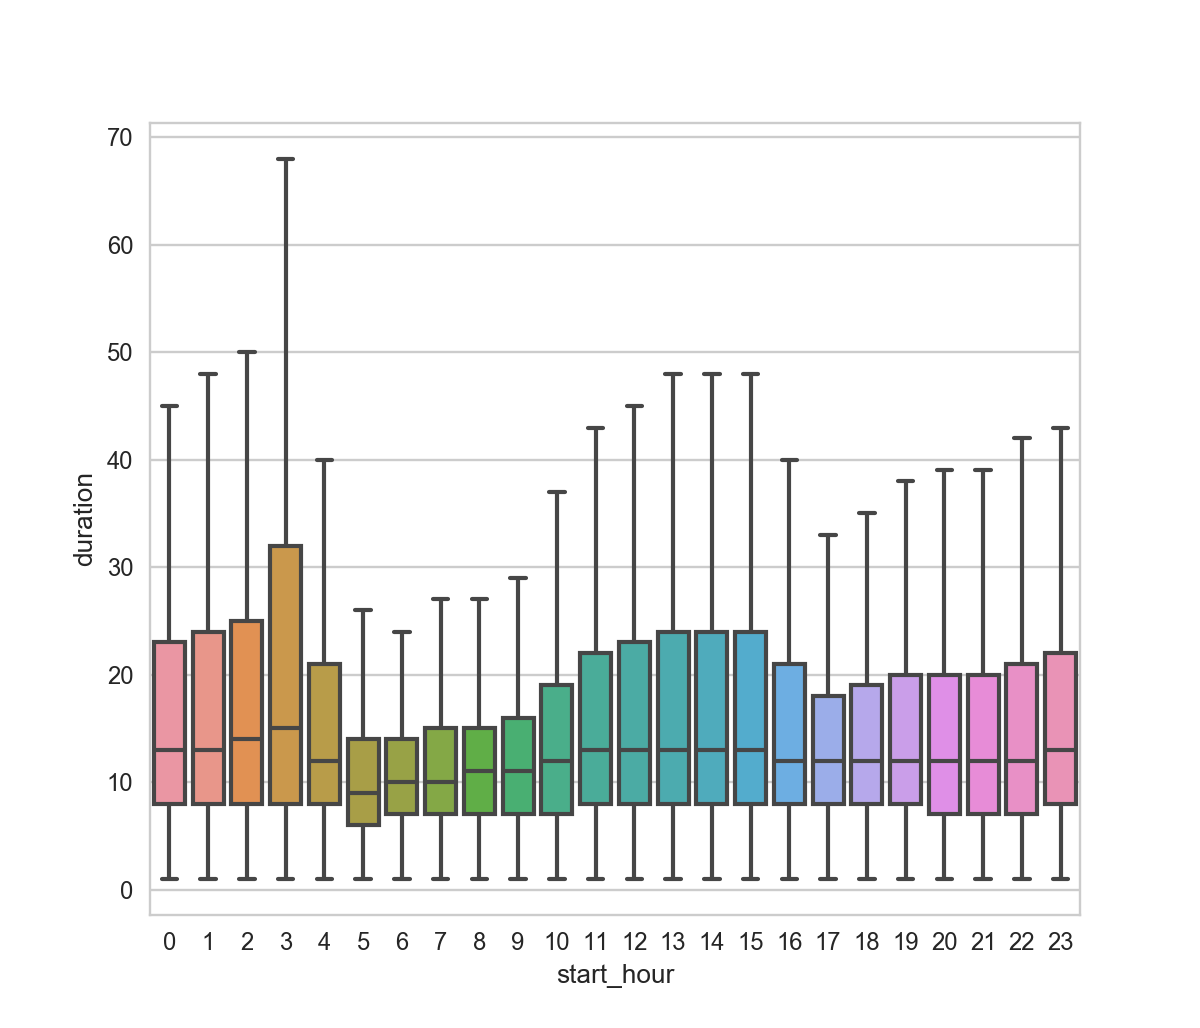

In [138]:
f4, ax4 = plt.subplots(figsize=(7, 6))
ax4 = sns.boxplot(x='start_hour', y='duration', showfliers=False, data=df_new.sample(frac=0.1))

### Plot duration vs day of the week

<IPython.core.display.Javascript object>


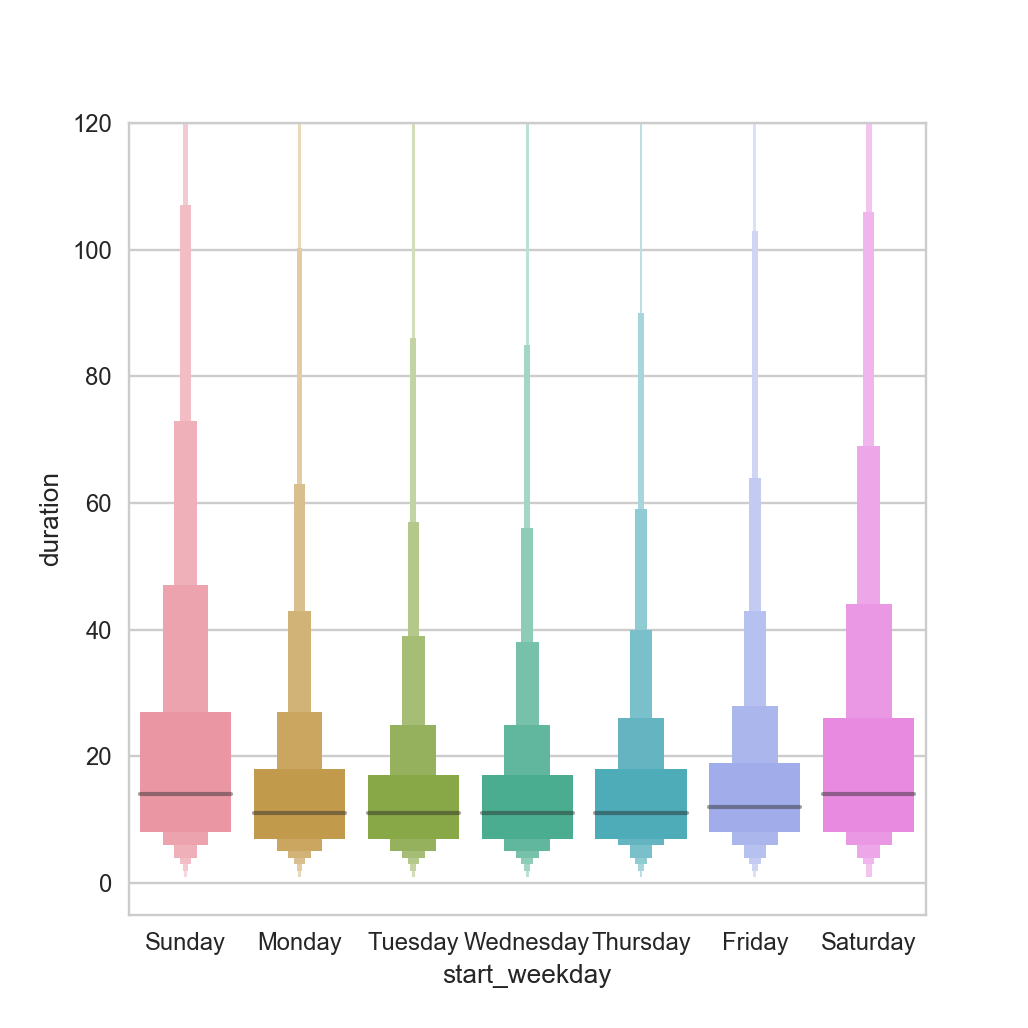

[(-5, 120)]

In [139]:
f5, ax5 = plt.subplots(figsize=(6, 6))
ax5 = sns.lvplot(x='start_weekday', y='duration', data=df_new.sample(frac=0.1))
ax5.set(ylim=[-5, 120])

### Plot duration vs bike_id

In [140]:
bike_dur = df_new.groupby('bike_id').mean()['duration'].reset_index().copy()
bike_dur.sort_values('duration', ascending=False).head(10)

,bike_id,duration
0,14,94.000000
103,2582,80.750000
546,3566,60.306122
380,3400,51.775000
520,3540,47.576190
1743,3466,46.060201
1796,3521,41.035714
1775,3500,40.103448
16,2495,39.875000
1912,3651,39.171875


<IPython.core.display.Javascript object>


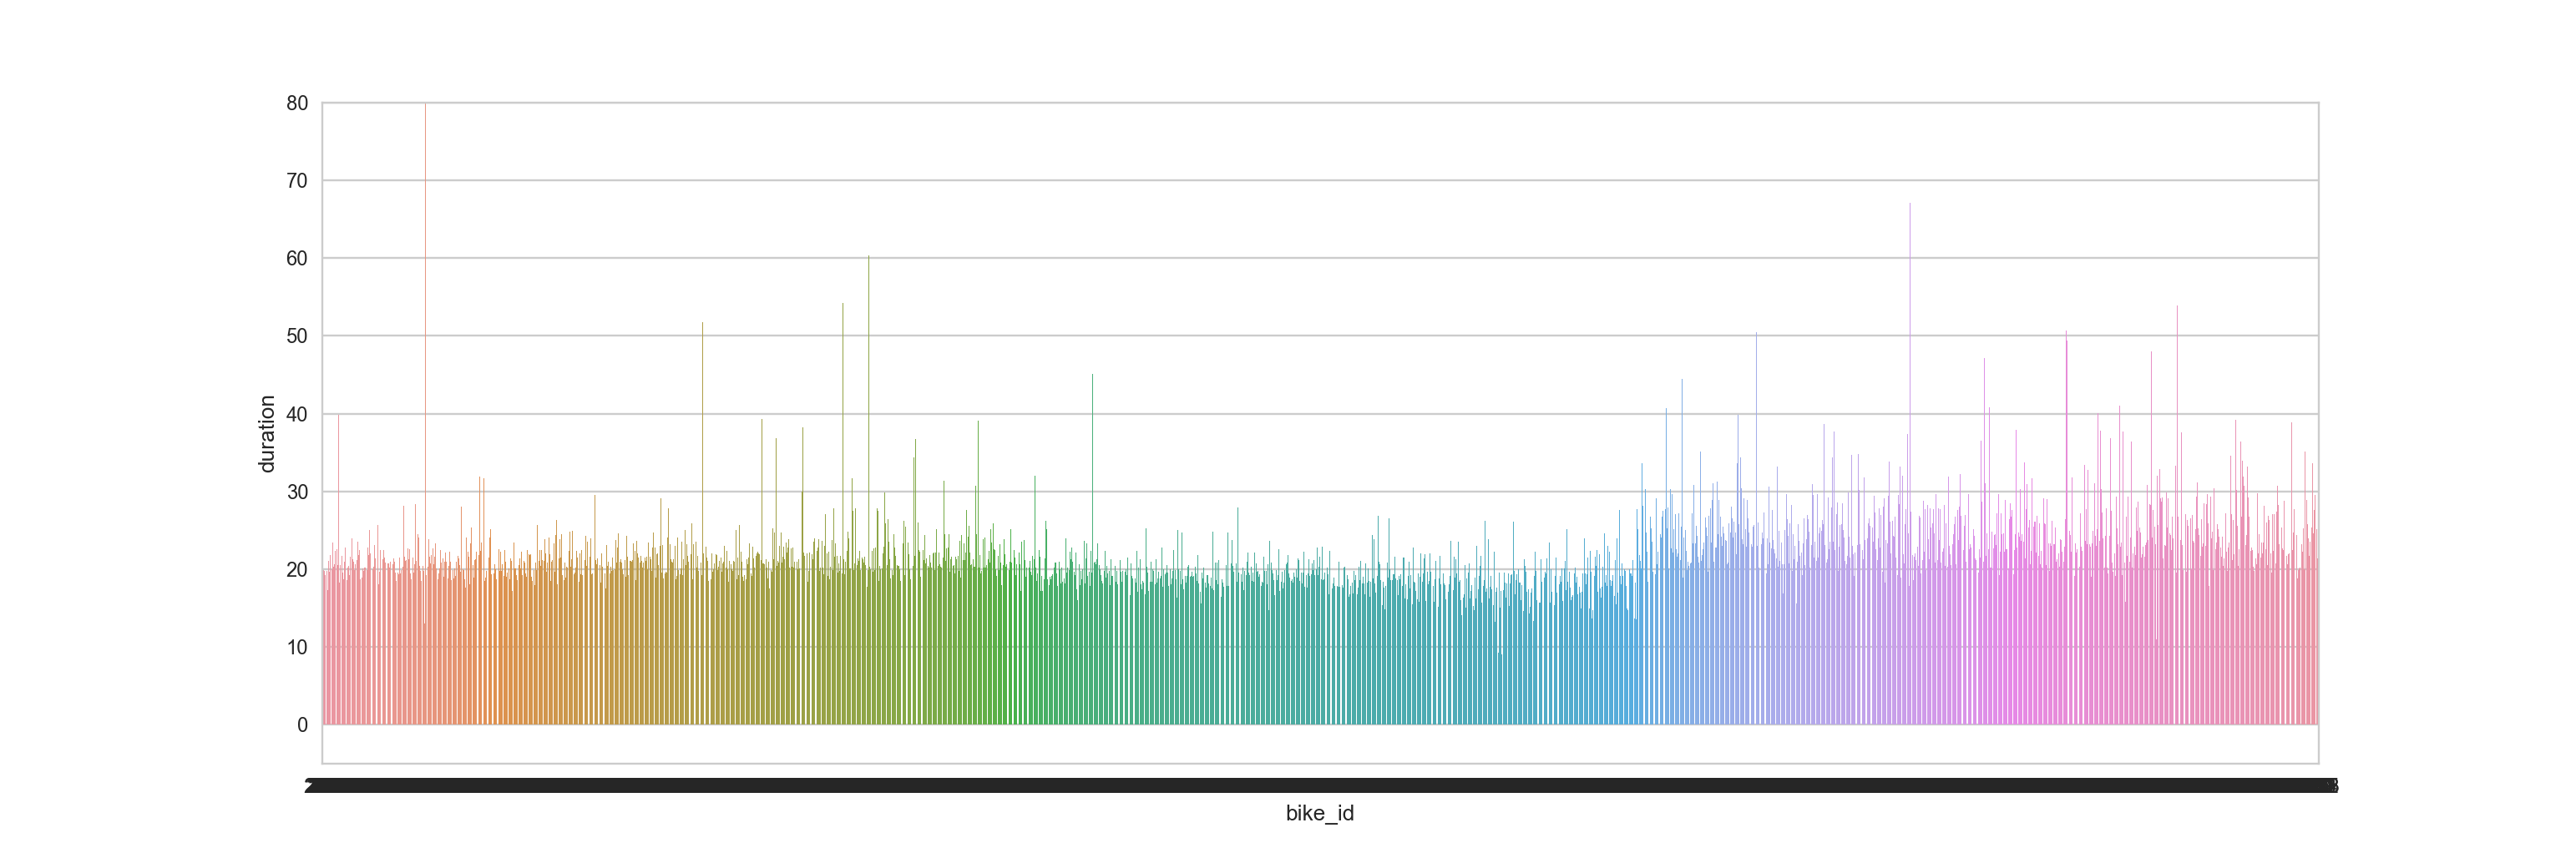

[(-5, 80)]

In [53]:
f6, ax6 = plt.subplots(figsize=(18, 6))
ax6 = sns.barplot(x='bike_id', y='duration', data=bike_dur)
ax6.set(ylim=[-5, 80])

### Resample start_time for plotting

In [141]:
df_time = df_new[['start_time', 'duration']].sort_values('start_time').copy()
df_time.set_index(pd.DatetimeIndex(df_time['start_time']), drop=True, inplace=True)
df_time.drop('start_time', axis='columns', inplace=True)
df_time.head(3)
df_month = df_time.resample('1M').mean()
df_week = df_time.resample('1W').mean()
df_day = df_time.resample('1D').mean()

,duration
start_time,
2015-04-23 07:44:00,1.0
2015-04-23 07:45:00,1.0
2015-04-23 07:46:00,2.0


### Plot duration's monthly variation

<IPython.core.display.Javascript object>


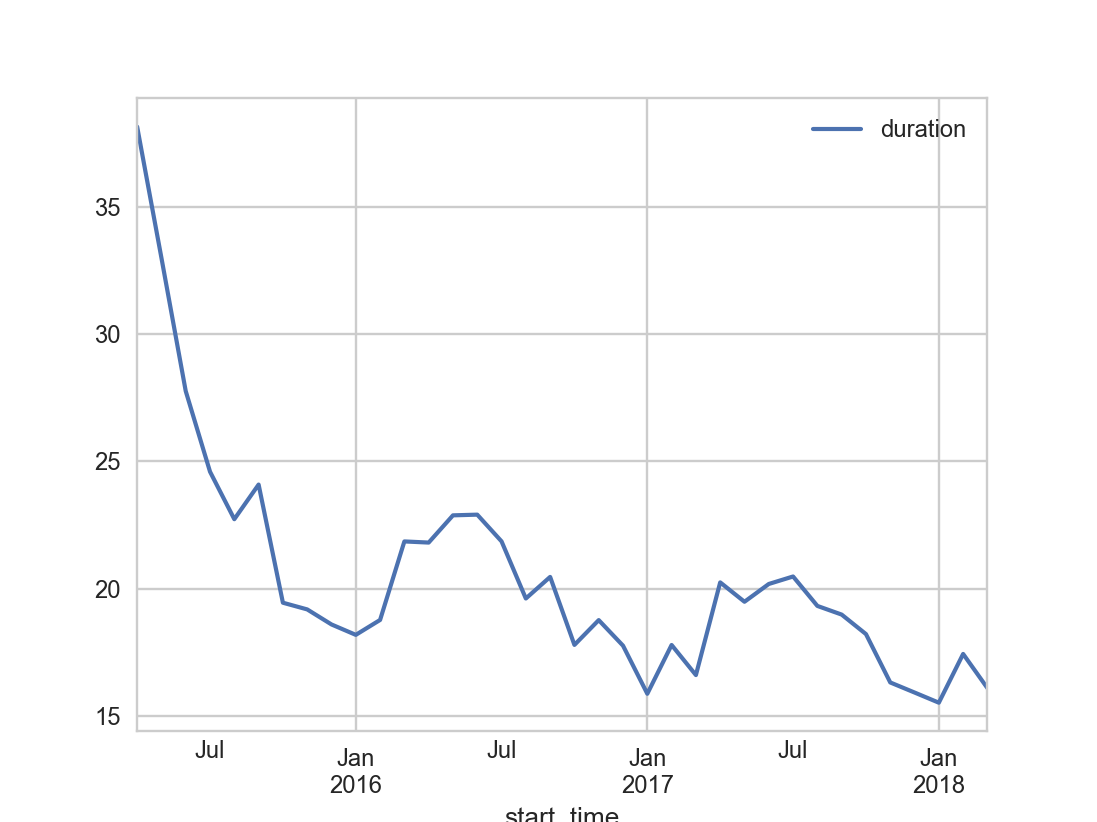

In [142]:
df_month.plot()

### Plot duration's weekly variation

<IPython.core.display.Javascript object>


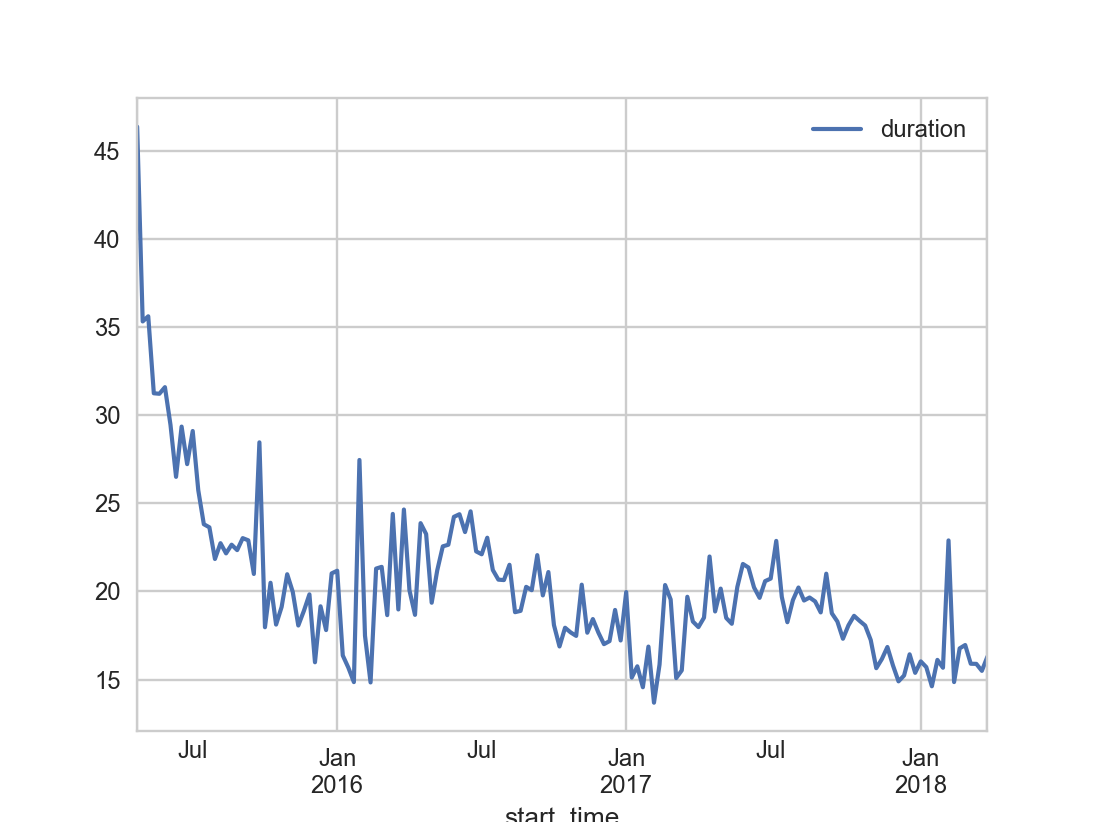

In [143]:
df_week.plot()

### Plot duration's daily variation

In [146]:
d1 = date(2017, 7, 1)
d2 = date(2017, 8, 30)
condi_day = (df_day.index.date>=d1)&(df_day.index.date<=d2)

<IPython.core.display.Javascript object>


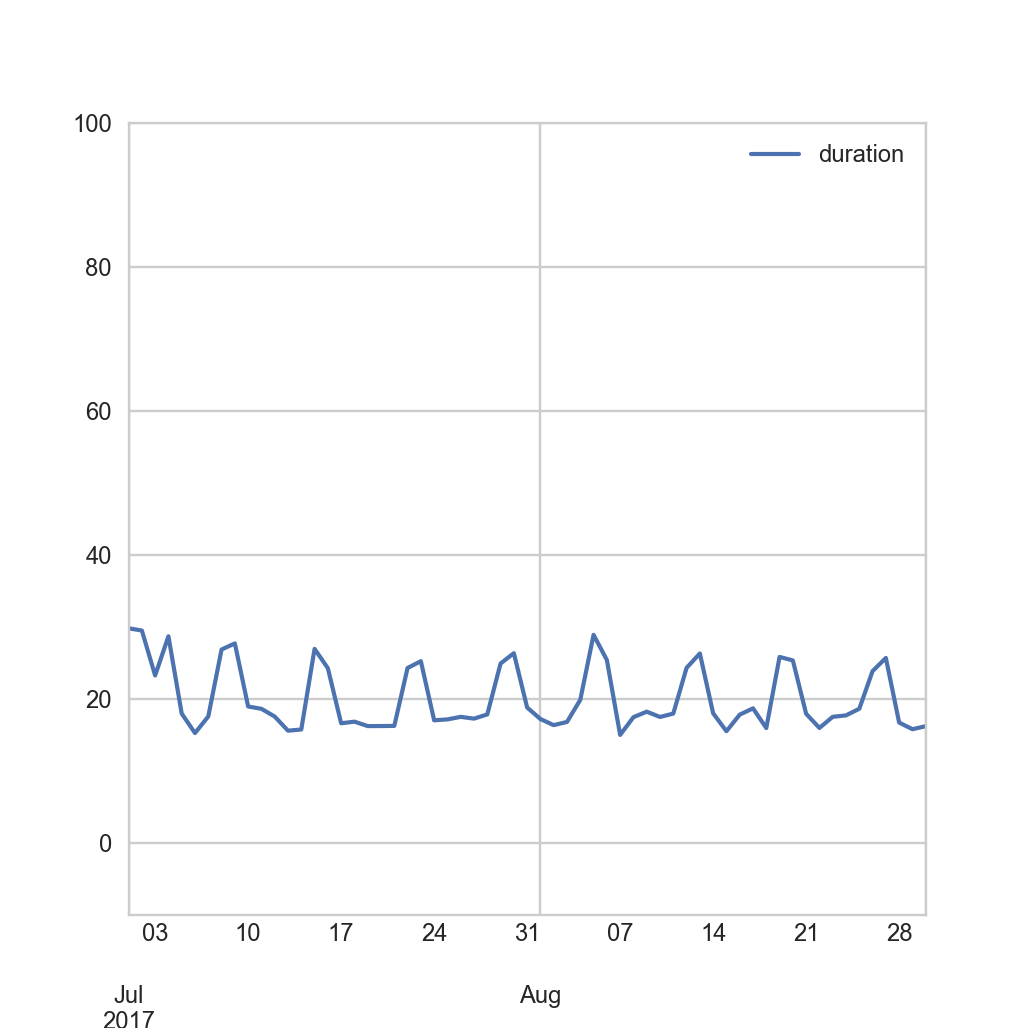

In [147]:
df_day[condi_day].plot(ylim=[-10,100],figsize=(6,6))

### Make a new column for business day

In [68]:
def is_business_day(date):
    return bool(len(pd.bdate_range(date, date)))

In [149]:
is_business_day(d2)

True

In [150]:
df_new['start_date'] = df_new['start_time'].dt.date
df_new['start_date'].min(); df_new['start_date'].max()

datetime.date(2015, 4, 23)

datetime.date(2018, 3, 31)

In [151]:
bday_index = pd.bdate_range(df_new['start_date'].min(), df_new['start_date'].max())
df_bday = pd.DataFrame({'start_date': bday_index, 'isBday': 1})
df_bday['start_date'] = df_bday['start_date'].dt.date

In [152]:
df_new = pd.merge(df_new, df_bday, how='left', on='start_date')
df_new['isBday'].fillna(0, inplace=True)
df_new['start_month'] = df_new.start_time.dt.month

### Plot duration's hour/month heatmap

<IPython.core.display.Javascript object>


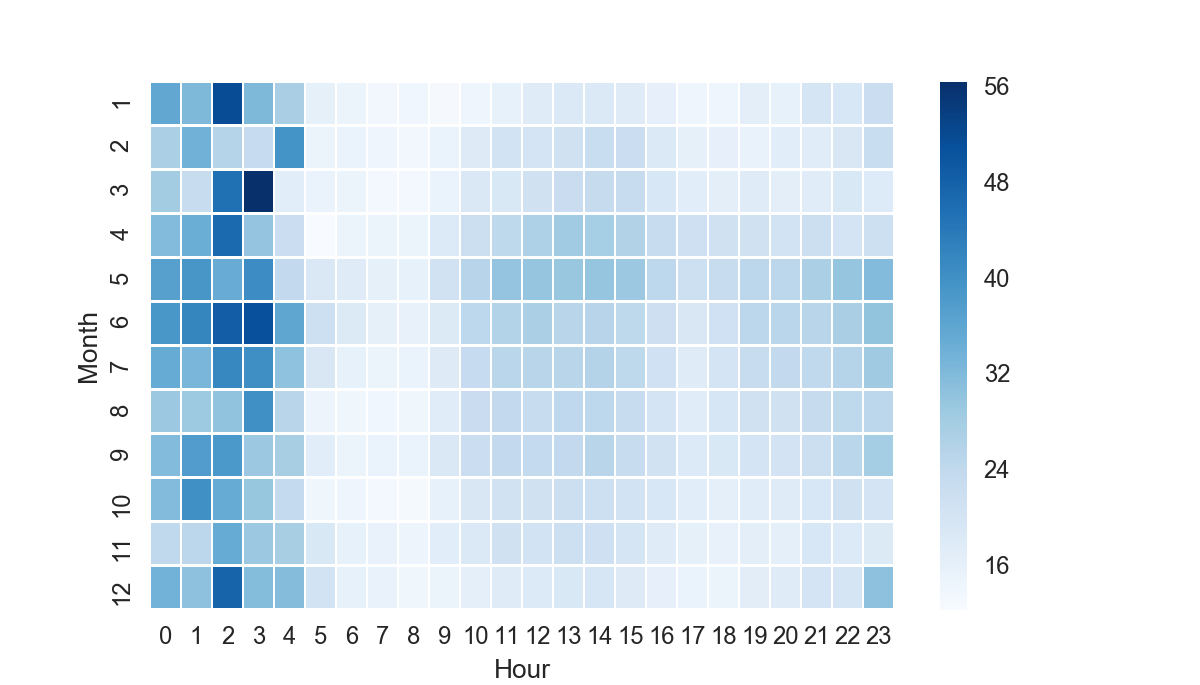

In [153]:
df_dur_month = df_new.groupby(['start_month', 'start_hour']).mean().duration.reset_index().copy()
df_dur_month.columns=['Month', 'Hour', 'Duration']
dur_month = df_dur_month.pivot('Month', 'Hour', 'Duration')

f7, ax7 = plt.subplots(figsize=(7, 4))
ax7 = sns.heatmap(dur_month, square=False, linewidths=.8, cmap='Blues')
f7.savefig('month_hour_duration.png', bbox_inches='tight')

### Plot duration's hour/weekday heatmap

<IPython.core.display.Javascript object>


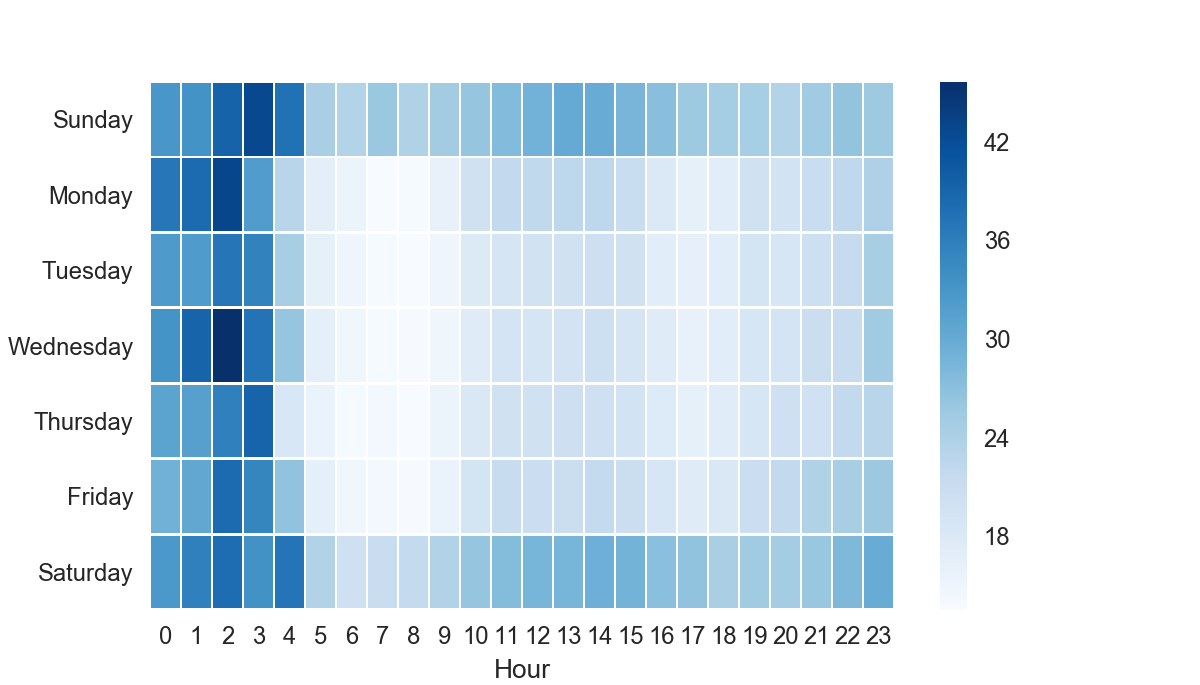

In [154]:
df_dur_week = df_new.groupby(['start_weekday', 'start_hour']).mean().duration.reset_index().copy()
df_dur_week.columns=['Day of the Week', 'Hour', 'Duration']
dur_week = df_dur_week.pivot('Day of the Week', 'Hour', 'Duration')

f8, ax8 = plt.subplots(figsize=(7, 4))
ax8 = sns.heatmap(dur_week, square=False, linewidths=.8, cmap='Blues')
f8.savefig('week_hour_duration.png', bbox_inches='tight')

# 8. Bucktize duration

In [155]:
df['duration_type'] = pd.cut(df['duration'], [0, 15, 30, 60, 1440], labels=["very short", "short", "medium", "long"])

# 9. Output a new data frame for modeling

In [83]:
df_new.to_pickle("indego_df_model.pkl")
df_new.to_csv("indego_df_model.csv")